## Classical Dynamics Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.optimize import minimize

In [2]:
@njit
def energy(s, W, H):
    s = s.astype(np.float64)  # Convert the spin array to float64
    pairwise_energy = np.dot(s, np.dot(W, s))
    local_field_energy = np.dot(H, s)
    return -pairwise_energy - local_field_energy

@njit
def metropolis_update(s, W, H, beta, flip_two_spins=False):
    s_new = np.copy(s)
    
    if flip_two_spins and np.random.rand() < 0.5:
        flip_indices = np.random.permutation(len(s))[:2]  # selects two spin indices to be flipped
    else:
        flip_indices = np.array([np.random.randint(len(s))])  # selects a single spin index to be flipped
    
    s_new[flip_indices] *= -1
    delta_E = energy(s_new, W, H) - energy(s, W, H)
    
    if delta_E < 0 or np.random.rand() < np.exp(-beta * delta_E):
        s = s_new
    
    return s

def simulate_dynamics(W, H, beta, steps, n_spins, flip_two_spins=False):
    s = np.array([np.random.choice(np.array([-1, 1])) for _ in range(n_spins)], dtype=np.int64)
    trajectory = np.empty((steps, n_spins), dtype=np.int64)
    
    for t in range(steps):
        s = metropolis_update(s, W, H, beta, flip_two_spins)
        trajectory[t] = s
    
    return trajectory


def boltzmann_distribution(W, H, beta):
    n_spins = len(H)
    all_states = np.array([[1 if digit=='0' else -1 for digit in f"{i:0{n_spins}b}"] for i in range(2**n_spins)])
    energies = np.array([energy(state, W, H) for state in all_states])
    probabilities = np.exp(-beta * energies)
    Z = np.sum(probabilities)
    return probabilities / Z

def check_convergence_to_boltzmann(W, H, beta, trajectory, tolerance=0.01):
    n_spins = len(H)
    boltzmann_probs = boltzmann_distribution(W, H, beta)

    # Count the occurrences of each unique spin state in the trajectory
    state_counts = {}
    for state in trajectory:
        state_tuple = tuple(state)
        if state_tuple in state_counts:
            state_counts[state_tuple] += 1
        else:
            state_counts[state_tuple] = 1

    # Calculate the empirical probabilities from the trajectory
    empirical_probs = np.zeros(2**n_spins)
    for idx, state in enumerate(np.array([[1 if digit=='0' else -1 for digit in f"{i:0{n_spins}b}"] for i in range(2**n_spins)])):
        state_tuple = tuple(state)
        if state_tuple in state_counts:
            empirical_probs[idx] = state_counts[state_tuple] / len(trajectory)

    # Check if the difference between the Boltzmann probabilities and the empirical probabilities is within the tolerance
    difference = np.abs(boltzmann_probs - empirical_probs)
    converged = np.all(difference <= tolerance)

    return converged, difference


In [3]:
def system_state(s):
    return ''.join(['↑' if spin == 1 else '↓' for spin in s])

def plot_combined_dynamics(W, H, beta, steps, n_spins, flip_two_spins=False):
    trajectory = simulate_dynamics(W, H, beta, steps, n_spins, flip_two_spins)
    
    system_states = [system_state(s) for s in trajectory]
    unique_system_states = sorted(list(set(system_states)))
    state_mapping = {state: idx for idx, state in enumerate(unique_system_states)}
    states = np.array([state_mapping[state] for state in system_states])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

    ax1.plot(states, label='System state', color ='MediumSeaGreen')
    ax1.set_xlabel('Time step')
    ax1.set_ylabel('System state')
    ax1.set_yticks(list(state_mapping.values()))
    ax1.set_yticklabels(list(state_mapping.keys()))
    ax1.legend()

    for i, spin_label in enumerate(['s{}'.format(i + 1) for i in range(n_spins)]):
        ax2.plot(trajectory[:, i], label=spin_label)
        
    ax2.set_xlabel('Time step')
    ax2.set_ylabel('Spin values')
    ax2.set_yticks([-1, 1])
    ax2.set_yticklabels(['-1', '1'])
    ax2.legend()

    plt.show()

def plot_convergence_to_boltzmann(W, H, beta, trajectory):
    n_spins = len(H)
    boltzmann_probs = boltzmann_distribution(W, H, beta)

    # Count the occurrences of each unique spin state in the trajectory
    state_counts = {}
    for state in trajectory:
        state_tuple = tuple(state)
        if state_tuple in state_counts:
            state_counts[state_tuple] += 1
        else:
            state_counts[state_tuple] = 1

    # Calculate the empirical probabilities from the trajectory
    empirical_probs = np.zeros(2**n_spins)
    for idx, state in enumerate(np.array([[1 if digit=='0' else -1 for digit in f"{i:0{n_spins}b}"] for i in range(2**n_spins)])):
        state_tuple = tuple(state)
        if state_tuple in state_counts:
            empirical_probs[idx] = state_counts[state_tuple] / len(trajectory)

    # Plot the Boltzmann probabilities and the empirical probabilities
    state_labels = [system_state(state) for state in np.array([[1 if digit=='0' else -1 for digit in f"{i:0{n_spins}b}"] for i in range(2**n_spins)])]
    x = np.arange(len(state_labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width / 2, boltzmann_probs, width, label='Boltzmann', color='SteelBlue', alpha=0.8)
    rects2 = ax.bar(x + width / 2, empirical_probs, width, label='Empirical', color='Coral', alpha=0.8)

    ax.set_ylabel('Probability')
    ax.set_xlabel('Spin states')
    ax.set_title('Boltzmann vs Empirical Probabilities')
    ax.set_xticks(x)
    ax.set_xticklabels(state_labels)
    ax.legend()

    plt.show()




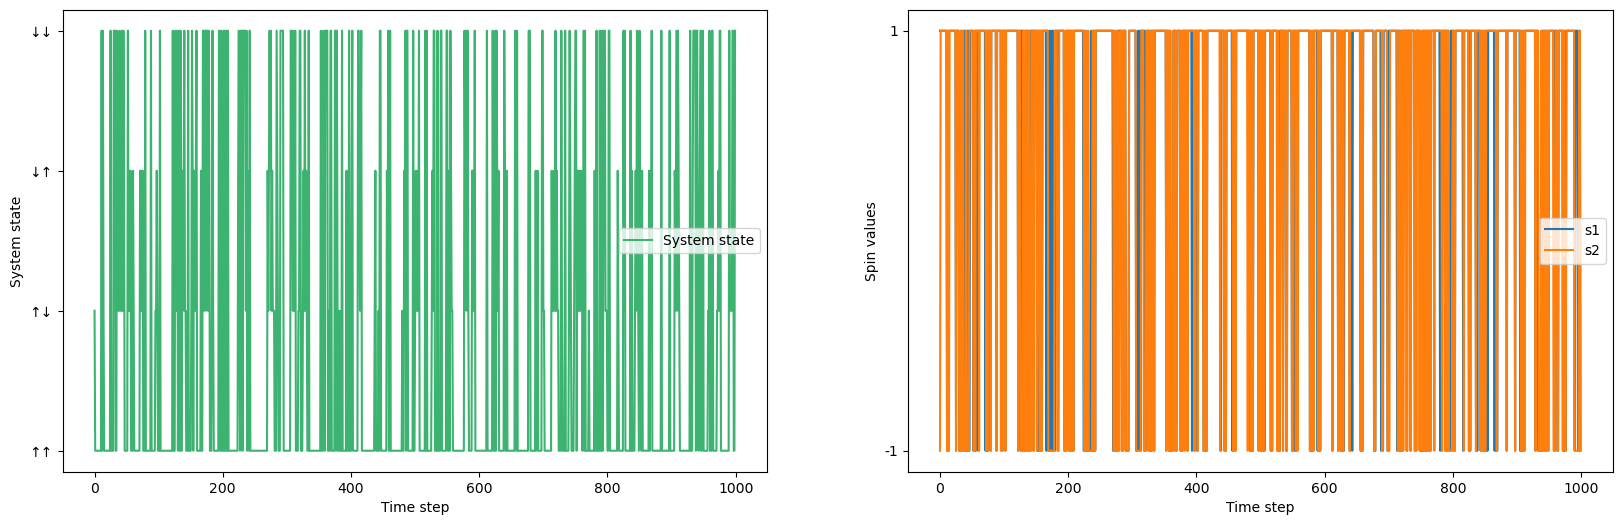

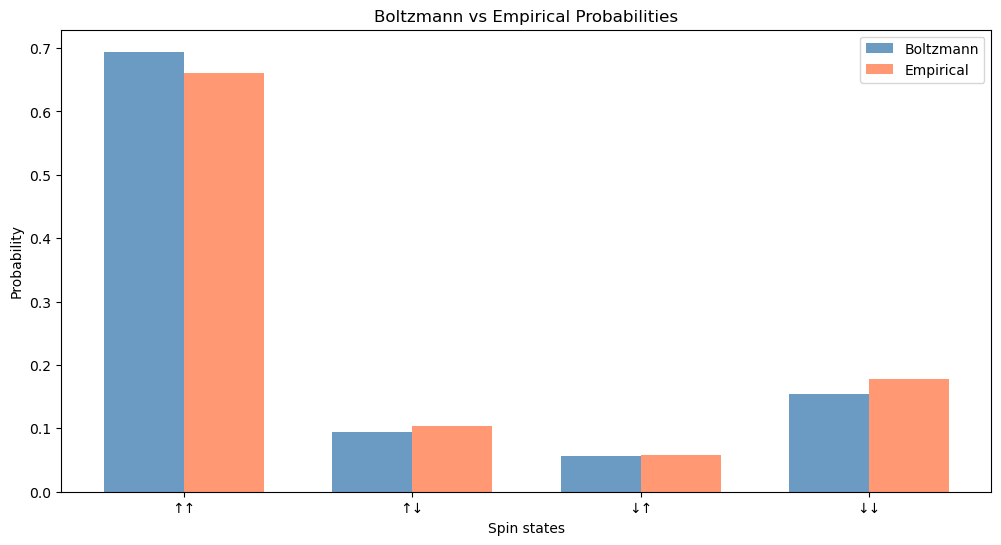

Converged: True
Difference: [0.03417909 0.01005308 0.00101831 0.02310771]


In [4]:
n_spins = 2
W = np.array([[1.0, 0.5], [1.0, 0.7],])
H = np.array([1.0, 0.5])
beta = 0.5
steps = 1000
tolerance = 0.1

trajectory = simulate_dynamics(W, H, beta, steps, n_spins)
plot_combined_dynamics(W, H, beta, steps, n_spins, flip_two_spins=True)
plot_convergence_to_boltzmann(W, H, beta, trajectory)

converged, difference = check_convergence_to_boltzmann(W, H, beta, trajectory, tolerance)

print(f"Converged: {converged}")
print(f"Difference: {difference}")


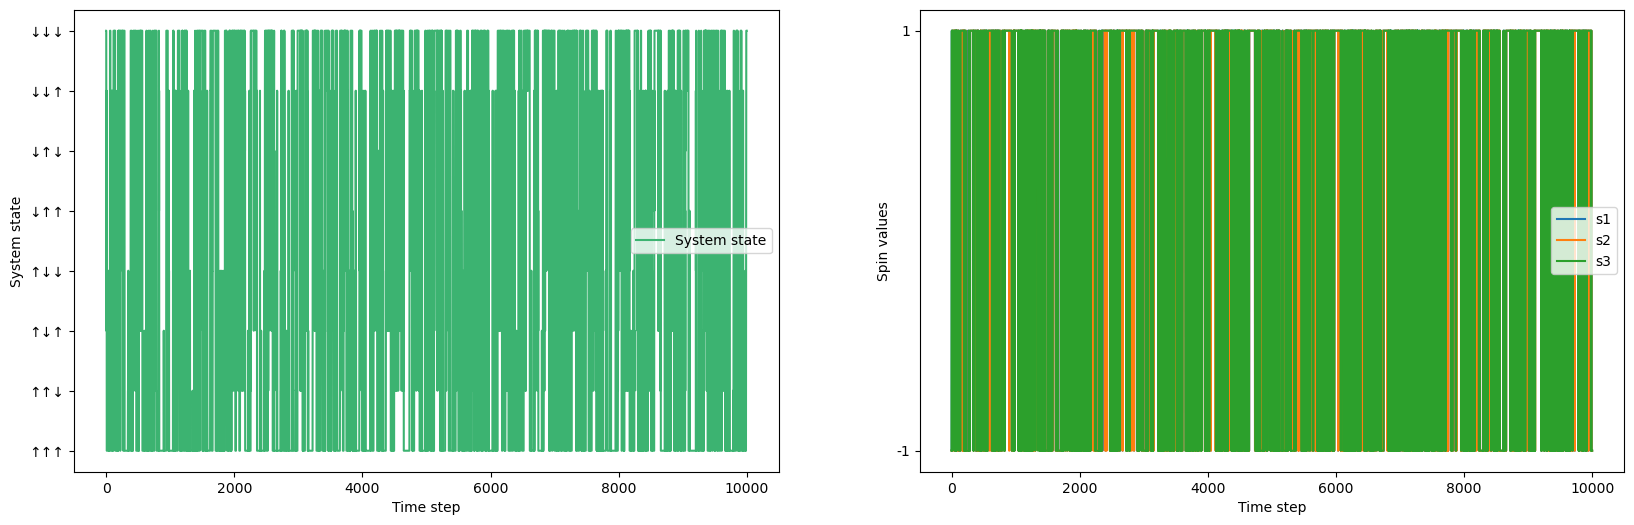

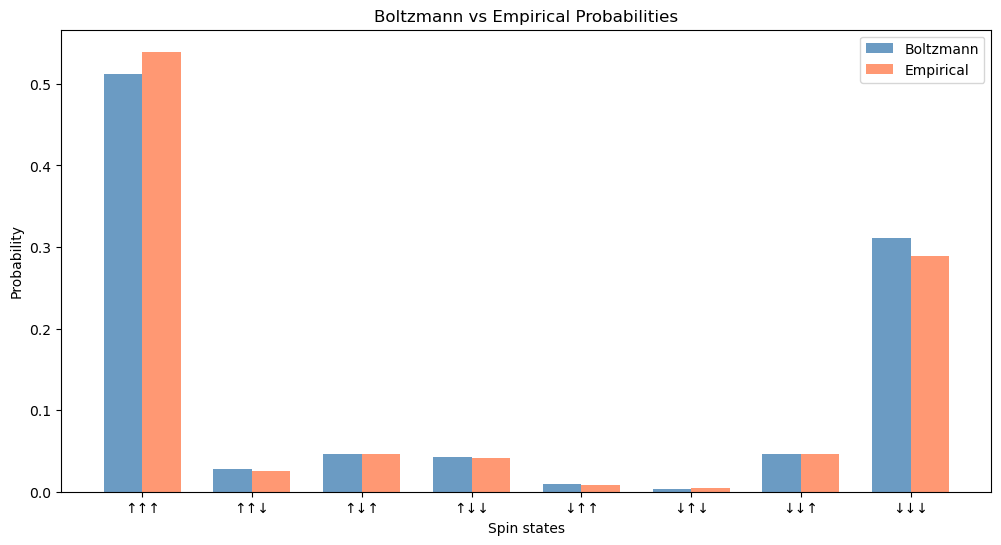

In [6]:
n_spins = 3
W = np.array([[0, 1.0, 0.5], [1.0, 0, 0.7], [0.5, 0.7, 0]])
H = np.array([1.0, -1.0, 0.5])
beta = 0.5
steps = 10000

trajectory = simulate_dynamics(W, H, beta, steps, n_spins)
plot_combined_dynamics(W, H, beta, steps, n_spins, flip_two_spins=True)
plot_convergence_to_boltzmann(W, H, beta, trajectory)



# Infering paramters from the dynamics

In [7]:
def log_likelihood(params, trajectory, beta):
    n_spins = trajectory.shape[1]
    
    W = np.reshape(params[:n_spins**2], (n_spins, n_spins))
    H = params[n_spins**2:]
    
    # Define all possible states
    all_states = np.array(list(itertools.product([-1, 1], repeat=n_spins)))
    
    # Calculate the partition function Z
    Z = np.sum([np.exp(-beta * energy(s, W, H)) for s in all_states])
    
    # Compute the Boltzmann probabilities for each state in the trajectory
    energies = np.array([energy(s, W, H) for s in trajectory])
    boltzmann_probabilities = np.exp(-beta * energies) / Z
    
    # Calculate the log-likelihood
    log_likelihood = np.sum(np.log(boltzmann_probabilities))
    return -log_likelihood


def infer_parameters(trajectory, beta, initial_guess=None):
    n_spins = trajectory.shape[1]
    n_params = n_spins**2 + n_spins
    
    if initial_guess is None:
        initial_guess = np.random.randn(n_params)
    
    result = minimize(log_likelihood, initial_guess, args=(trajectory, beta), method='L-BFGS-B')
    return result.x

In [8]:
# Example usage:
w = 1.0
h = 0.3
beta = 0.5
steps = 100000

trajectory = simulate_dynamics(w, h, beta, steps, flip_two_spins=True)
inferred_w, inferred_h = infer_parameters(trajectory, beta)
print(f"Inferred w: {inferred_w}, Inferred h: {inferred_h}")

TypeError: simulate_dynamics() missing 1 required positional argument: 'n_spins'